In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/bookcrossing'

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
[df, df_train,df_valid,df,df_ratings,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/reads.pkl','rb'))

## Dataset and DataLoader

In [4]:
len(df_train), len(df_valid)

(105283, 105283)

In [5]:
class autoencdata (Dataset):
    def __init__(self,dfX,dfXv):
        self.dfX,self.dfXv=dfX,dfXv
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor(self.dfXv.iloc[idx].values)

In [6]:
dstrain=autoencdata(df_train, df_valid)
#dsvalid=autoencdata(df_valid)

In [7]:
bs=12

In [8]:
# Create a DataLoader object
dltrain=DataLoader(dstrain,batch_size=bs,shuffle=False)
#dlvalid=DataLoader(dsvalid,batch_size=bs,shuffle=False) 

In [9]:
df['rating'].min(),df['rating'].max()

(0, 10)

In [10]:
df_train.shape

(105283, 340556)

## Create the Model Architecture for the Encoder

In [11]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [12]:
class autoencoder (nn.Module):    
    def __init__(self,n_inp=9724,hidden=[50,10],dropouts=[0,0,0],rating_range=[0.5,5]):
        super().__init__()
        self.n_inp,self.hidden,self.dropouts,self.rating_range=n_inp,hidden,dropouts,rating_range
        encoder=[hidden_layer(n_inp if i==0 else hidden[i-1],hidden[i],dropouts[i],\
                              nn.Sigmoid() if i<len(hidden)-1 else nn.Tanh()) for i in range(len(hidden))]
        self.encoder=nn.Sequential(*encoder)
        hidden=hidden[::-1]
        num_steps=len(hidden)-1
        dropouts=dropouts[num_steps:]
        decoder=[hidden_layer(hidden[i],hidden[i+1] if i<len(hidden)-1 else n_inp,dropouts[i]) for i in range(len(hidden)-1)]
        self.decoder=nn.Sequential(*decoder)
        self.fc=nn.Linear(hidden[-1],n_inp)
        self.initialize()
        self.criterion=nn.MSELoss()
    
    def initialize(self):
        for x in self.encoder:
            nn.init.kaiming_normal_(x[0].weight.data)
        for x in self.decoder:
            nn.init.kaiming_normal_(x[0].weight.data)

    def forward (self,Xb):
        encoded=self.encoder(Xb)
        decoded=self.decoder(encoded)
        out=self.fc(decoded)
        outv=out.clone()
        out[Xb==0]=0
        loss=self.criterion(out,Xb)
        return outv,loss, out

In [13]:
autoenc=autoencoder(df_train.shape[1],[25,3],[0,0,0])

In [14]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=340556, out_features=25, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
    (1): Sequential(
      (0): Linear(in_features=25, out_features=3, bias=True)
      (1): Tanh()
      (2): Dropout(p=0)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3, out_features=25, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
  )
  (fc): Linear(in_features=25, out_features=340556, bias=True)
  (criterion): MSELoss()
)

In [15]:
for Xb,Xb_v in dltrain:
    print (Xb)
    break

tensor([[7., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 9.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [17]:
Xb.size()

torch.Size([12, 9724])

In [18]:
Xb.squeeze(0)

tensor([[4., 0., 4.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [19]:
preds,loss,_=autoenc.forward(Xb)

In [20]:
loss.backward()

In [21]:
preds.size()

torch.Size([12, 9724])

In [22]:
nn.MSELoss

torch.nn.modules.loss.MSELoss

In [23]:
device="cuda:1"

In [24]:
wd=1e-4
#wd=1e-1

In [25]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
#optimizer=torch.optim.SGD(model_sentiment.parameters(),lr=1e-2,momentum=0.9, weight_decay=wd)
metric_fn=None

In [26]:
len(dltrain)

51

In [27]:
import matplotlib.pyplot as plt

In [28]:
dltrain.batch_size

12

In [29]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Xb_v,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss,preds_train=self.model(Xb)
        # denominator is the average of the error with non-zero ratings

        mean_corrector = Xb.size(0)*Xb.size(1)/(torch.sum(Xb > 0).float() + 1e-10)
        mean_corrector_v = Xb_v.size(0)*Xb_v.size(1)/(torch.sum(Xb_v > 0).float() + 1e-10)

        with torch.no_grad():
            
            preds[Xb_v==0]=0
            loss_v=self.model.criterion(preds,Xb_v)
            
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
                acc_v=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=torch.sqrt(loss.item()*mean_corrector)
        myloss_v=torch.sqrt(loss_v.item()*mean_corrector_v)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc,myloss_v,acc_v
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_loss_v,epoch_acc_v=0,0

        for Xb,Xb_v in iterator:
            Xb=Xb.to(self.device)
            Xb_v=Xb_v.to(self.device)
            #Xb=Xb.squeeze(0)
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc,loss_v,acc_v=self.fit(Xb,Xb_v,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            epoch_loss+=loss
            epoch_acc+=acc
            epoch_loss_v+=loss_v
            epoch_acc_v+=acc_v
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)} {epoch_loss_v/(k)} ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_loss_v=epoch_loss_v/len(iterator)
        epoch_acc_v=epoch_acc_v/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_loss_v,epoch_acc_v
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):
        
        
            
        
        for epoch in range(n_epochs):                

            loss,acc,lossv,accv=self.run_epoch(dltrain,True)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss}  Valid Loss:{lossv} ')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [30]:
autoenc=autoencoder(df_train.shape[1],[25,3],[0.6,0.6,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)


In [31]:
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0)

In [32]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=9724, out_features=25, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.6)
    )
    (1): Sequential(
      (0): Linear(in_features=25, out_features=3, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.6)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3, out_features=25, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.6)
    )
  )
  (fc): Linear(in_features=25, out_features=9724, bias=True)
  (criterion): MSELoss()
)

In [33]:
len(dltrain)

51

In [34]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

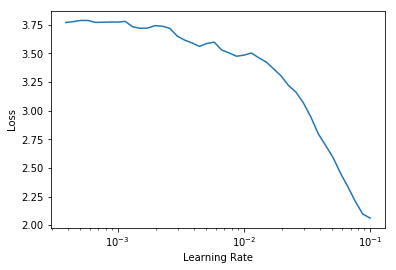

In [35]:
learner.plot_lrs(10)

In [52]:
autoenc=autoencoder(df_train.shape[1],[25,3],[0.25,0.25,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=3e-2,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=3e-2,end_lr=5e-4)

In [53]:
learner.run_epochs(dltrain,None,31)

Epoch:0 Learning rate 0.03 Weight Decay 1e-07 Train Loss:1.8376468420028687  Valid Loss:1.853797197341919 
Epoch:1 Learning rate 0.0038729833462074164 Weight Decay 1e-07 Train Loss:1.1463274955749512  Valid Loss:1.3080575466156006 
Epoch:2 Learning rate 0.0004999999999999999 Weight Decay 1e-07 Train Loss:1.0702520608901978  Valid Loss:1.2543089389801025 
Epoch:3 Learning rate 0.03 Weight Decay 1e-07 Train Loss:1.1628687381744385  Valid Loss:1.298978567123413 
Epoch:4 Learning rate 0.010779123358892525 Weight Decay 1e-07 Train Loss:1.0666176080703735  Valid Loss:1.2507163286209106 
Epoch:5 Learning rate 0.003872983346207416 Weight Decay 1e-07 Train Loss:0.994176983833313  Valid Loss:1.2095634937286377 
Epoch:6 Learning rate 0.0013915788418568699 Weight Decay 1e-07 Train Loss:0.9919460415840149  Valid Loss:1.2129087448120117 
Epoch:7 Learning rate 0.0004999999999999998 Weight Decay 1e-07 Train Loss:0.9839980602264404  Valid Loss:1.2220195531845093 
Epoch:8 Learning rate 0.03 Weight Decay

In [54]:
autoenc.encoder[0][0].weight.data.shape

torch.Size([25, 9724])

In [55]:
autoenc.encoder[1][0].weight.data.shape

torch.Size([3, 25])

In [56]:
user_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
user_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [57]:
from scipy.special import expit

df_train_user_autoenc=np.tanh(expit(df_train@user_mtx_1_weights.T)@user_mtx_2_weights.T)
df_valid_user_autoenc=np.tanh(expit(df_valid@user_mtx_1_weights.T)@user_mtx_2_weights.T)

In [58]:
df_train_user_autoenc=(expit(df_train@user_mtx_1_weights.T)@user_mtx_2_weights.T)
df_valid_user_autoenc=(expit(df_valid@user_mtx_1_weights.T)@user_mtx_2_weights.T)

In [59]:
df_train_user_autoenc.shape,df_valid_user_autoenc.shape

((610, 3), (610, 3))

In [60]:
df_train_user_autoenc.columns=['user_autoenc'+str(i) for i in range(df_train_user_autoenc.shape[1])]

In [61]:
df_valid_user_autoenc.columns=['user_autoenc'+str(i) for i in range(df_valid_user_autoenc.shape[1])]

In [62]:
df_train_user_autoenc.reset_index(inplace=True)

In [63]:
df_valid_user_autoenc.reset_index(inplace=True)

In [64]:
import pickle
pickle.dump([df_train_user_autoenc,df_valid_user_autoenc,user_mtx_1_weights,user_mtx_2_weights],open(f'{DATAPATH}/inter/user_autoenc_weights.pkl','wb'))

In [65]:
autoenc.encoder

Sequential(
  (0): Sequential(
    (0): Linear(in_features=9724, out_features=25, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.25)
  )
  (1): Sequential(
    (0): Linear(in_features=25, out_features=3, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.25)
  )
)

In [51]:
df_train_user_autoenc.shape

(610, 11)